<a href="https://colab.research.google.com/github/CHADHURBALA/resnet/blob/main/Cifar10_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import math
import numpy as np
import scipy
import h5py
from tensorflow.keras import datasets
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization  
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt




In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    # SHORTCUT PATH
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


In [ ]:
def ResNet50(input_shape=(32, 32, 3), classes=10):
    

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)

    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # X = identity_block(X, 3, [64, 64, 256], stage=2, block='a')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    
    X = GlobalAveragePooling2D()(X)
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


In [ ]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_7 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_7[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']           

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Function to create onehot encoding for different class categories
def convert_to_one_hot(Y, C):
    """
    one hot encoding output classes

    Parameters
    ----------
    Y : array
        output array of different classes
    C : int
        number of classes in output array

    Returns
    -------
    Y : array
        one hot encoded output array of different classes
    """
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = datasets.cifar10.load_data()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 10).T
Y_test = convert_to_one_hot(Y_test_orig, 10).T

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [ ]:
history = model.fit(X_train, Y_train, epochs = 25, batch_size = 32, validation_split = 0.2 , shuffle=True)

Epoch 1/25
1250/1250 [==============================] - 64s 51ms/step - loss: 1.9210 - accuracy: 0.3770 - val_loss: 2.1070 - val_accuracy: 0.3030
Epoch 2/25
1250/1250 [==============================] - 64s 51ms/step - loss: 1.8032 - accuracy: 0.4072 - val_loss: 1.7709 - val_accuracy: 0.4320
Epoch 3/25
1250/1250 [==============================] - 62s 50ms/step - loss: 1.6686 - accuracy: 0.4364 - val_loss: 5.8221 - val_accuracy: 0.4066
Epoch 4/25
1250/1250 [==============================] - 63s 50ms/step - loss: 1.5834 - accuracy: 0.4791 - val_loss: 1.9089 - val_accuracy: 0.4015
Epoch 5/25
1250/1250 [==============================] - 63s 50ms/step - loss: 1.4289 - accuracy: 0.5099 - val_loss: 1.3810 - val_accuracy: 0.5322
Epoch 6/25
1250/1250 [==============================] - 64s 51ms/step - loss: 1.3239 - accuracy: 0.5491 - val_loss: 1.2683 - val_accuracy: 0.5477
Epoch 7/25
1250/1250 [==============================] - 62s 50ms/step - loss: 1.2950 - accuracy: 0.5646 - val_loss: 2.4906 -

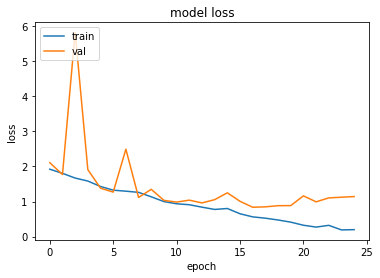

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


313/313 [==============================] - 5s 14ms/step - loss: 1.1996 - accuracy: 0.7046
Loss = 1.199558973312378
Test Accuracy = 0.7045999765396118


Pick a number: 99
1/1 [==============================] - 0s 28ms/step


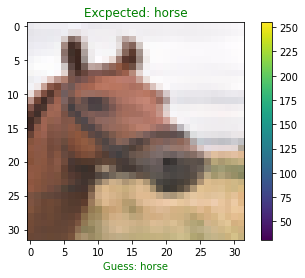

In [ ]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, im, correct_label):
  class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
  prediction = list(model.predict(np.array([im])))
  
  prediction = prediction[0]
  # print(prediction)

  r = np.argmax(prediction)
  # print(r)
    
  predicted_class = class_names[r]

  show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
  plt.figure()
  plt.imshow(img)
  plt.title("Excpected: " + f"{label}", color='green')
  plt.xlabel("Guess: " + f"{guess}", color='green')
  plt.colorbar()
  plt.grid(False)
  plt.show()


def get_number():
  while True:
    num = input("Pick a number: ")
    if num.isdigit():
      num = int(num)
      if 0 <= num <= 10000:
        return int(num)
    else:
      print("Try again...")

num = get_number()
image = X_test_orig[num]
im = X_test[num]
label = list(Y_test[num])

l= 1000
for index, val in enumerate(label):
  if val == 1:
    l = index
    break


predict(model, image, im, l)
